In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression as LogisticRegression
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score,  make_scorer,  hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Read in Data

In [2]:
x_test = pd.read_csv('ImputedX_test.csv')
x_train = pd.read_csv('ImputedX_train.csv')
y_test = pd.read_csv('Y_test.csv')
y_train = pd.read_csv('Y_train.csv')
columns = y_train.columns

In [3]:
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

In [29]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Logistic Regression

In [11]:
log_reg = LogisticRegression(penalty='l2', 
                           dual=False, 
                           tol=0.0001, 
                           C=1.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight="balanced", 
                           random_state=None, 
                           solver='liblinear', 
                           max_iter=100, 
                           multi_class='ovr', 
                           n_jobs=1)

ovr = OneVsRestClassifier(log_reg,n_jobs=3)

In [34]:


parameters = {'estimator__penalty':['l2'], 'estimator__C': [1e-15, 1e-10, 0.1, 1]}
best_models = []
predictions = pd.DataFrame()
for i in range(y_train.shape[1]):
    grid_model = GridSearchCV(ovr, 
              parameters, 
              scoring="f1", 
              fit_params=None, 
              n_jobs=4, 
              iid=True, 
              refit=True, 
              cv=3, 
              verbose=0, 
              pre_dispatch='2*n_jobs', 
              error_score='raise')
    grid_model.fit(x_train, y_train[:,i])
    grid_model.best_estimator_.fit(x_train, y_train[:,i])
    best_models.append(grid_model.best_estimator_)
    predictions[columns[i]] = grid_model.best_estimator_.predict(x_test)

/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:

In [35]:
logistic_pred = predictions

In [36]:
logistic_pred.to_csv("LogisticResults.csv",index=False)

In [37]:
f1_score(y_test, logistic_pred, average = 'weighted')

0.4040773463119352

## Random Forest

In [38]:
params = {"max_features": ["log2", 500, None],
          "max_depth": [100, 250, 500],
          "n_estimators": [10, 20, 50]}

In [39]:
rfc_multilab = GridSearchCV(RandomForestClassifier(n_jobs = -1), 
                   cv=5, 
                   param_grid = params, 
                   scoring=make_scorer(f1_score, average='weighted'))

rfc_multilab.fit(x_train, y_train)
rf_pred = rfc_multilab.predict(x_test)

/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

In [40]:
pd.DataFrame(rf_pred,columns = columns).to_csv("RandomForestResults.csv",index=False)

In [41]:
f1_score(y_test, rf_pred, average = 'weighted')

/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.29199395248281562

## SVM

In [42]:
c_param = [1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,0.1]
svm_pred = pd.DataFrame()
genres = columns 

for i in range(len(genres)):
    Y_curr = y_train[:,i]
    Y_test_curr = y_test[:,i]
    
    svm = SVC(class_weight = 'balanced', C = c_param[i], kernel = 'linear')
    svm.fit(x_train, Y_curr)

    y_pred = svm.predict(x_test)
    svm_pred[columns[i]] = (y_pred)

In [43]:
svm_pred.to_csv("SVMResults.csv",index=False)

In [44]:
f1_score(y_test, svm_pred, average = 'weighted')

0.39964434584875197

_____________
# Ensemble Model

In [8]:
svm = pd.read_csv("SVMResults.csv")
rf = pd.read_csv("RandomForestResults.csv")
log = pd.read_csv("LogisticResults.csv")
d = pd.concat([svm, rf, log], axis=1)

indices = np.arange(d.shape[0])
X_train_final, X_test_final, y_train_final, y_test_final, idtrain, idtest = train_test_split(d, y_test, indices, test_size=0.33)

pd.DataFrame(idtest).to_csv("test_set_indices.csv")

print(X_train_final.shape)
print(X_test_final.shape)

(1880, 51)
(927, 51)


In [9]:
params = {'estimator__penalty':['l2'], 'estimator__C': [1e-15, 1e-10, 0.1, 1]}

In [12]:
results = pd.DataFrame()
for i in columns:
    training_data = X_train_final[['svm_'+i,'rf_'+i, 'Log_'+i]]
    test_data = X_test_final[['svm_'+i,'rf_'+i, 'Log_'+i]]
    
    train_labels = y_train_final[:,list(columns).index(i)]    

    ensemble_multilab = GridSearchCV(ovr, 
                       cv=5, 
                       param_grid = params, 
                       scoring=make_scorer(f1_score, average='weighted'))

    ensemble_multilab.fit(training_data, train_labels)
    ensemble_multilab_pred = ensemble_multilab.predict(test_data)
    results[i] = ensemble_multilab_pred

/Users/courtneycochrane/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
f1_score(y_test_final, results, average = 'weighted')

0.41925003855425091

In [14]:
pd.DataFrame(results,columns = columns).to_csv("EnsembleResults.csv",index=False)

# Neural Net

In [4]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras import backend as K
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#import PIL
from PIL import Image
import pandas as pd
import random
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [5]:
data = pd.read_csv('id_genre_pairs.csv')
movie_ids = list(data['movie_id'])
data = np.array(data)
idtest = list(pd.read_csv("test_set_indices.csv")['0'])
test_movie_ids = list(pd.read_csv('TestSetMovies.csv', header = None)[0])

test_ids = []
for i in idtest:
    test_ids.append(test_movie_ids[i])

print(len(test_ids))

pd.DataFrame(test_ids).to_csv('Ensemble IDs.csv')

927


In [6]:
import os

test = []
test_labels = []
train = []
train_labels = []
actual_test_labels = []
for i in test_ids:
    try:
        img = load_img('Movie Posters Resized 32x32/'+str(i)+'.jpg')
        test.append(img_to_array(img))
        for row in data:
            if row[0] == i:
                test_labels.append(row[1:])
                break
        actual_test_labels.append(i)
    except:
        pass


    
for i in movie_ids:
    if i not in test_ids:
        try:
            img = load_img('Movie Posters Resized 32x32/'+str(i)+'.jpg')
            train.append(img_to_array(img))
            for row in data:
                if row[0] == i:
                    train_labels.append(row[1:])
                    break
                    
        except:
            pass


In [7]:
img_rows, img_cols = 32, 32
num_classes = 17

x_train = np.array(train) 
x_test = np.array(test)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
    
    
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (13786, 32, 32, 3)
x_test shape: (927, 32, 32, 3)
13786 train samples
927 test samples


In [8]:
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score

import keras.backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout

def accuracy_with_threshold(y_true, y_pred):
    threshold = 0.1
    y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())
    return K.mean(K.equal(y_true, y_pred))

from keras import regularizers

# smaller batch size means noisier gradient, but more updates per epoch
#batch_size = 256
batch_size=512 # Just for running locally - change this!
# number of iterations over the complete training data
epochs = 50
#epochs=1 # Just for testing - change this!
precisions = []
recalls = []
f1s = []
parameters = []
model_histories = []
# CV for number of layers, number of dense layers, sgd vs. adam, regularization constant, and learning rate 
for n_conv_layers in [1]:
    for n_dense_layers in [1]:
        for lrate in [0.001]:
            for adaptive_change in [0.01]:
                log_dir_string = "cv"
                log_dir_string += str(lrate)
                log_dir_string += str(adaptive_change)
                K.clear_session()
                model = Sequential()
                model.add(Conv2D(16, kernel_size=(5, 5), 
                                 activation='relu', 
                                 kernel_regularizer=regularizers.l2(0.01),
                                 input_shape=input_shape))
                model.add(MaxPooling2D(pool_size=(2, 2)))

                if n_conv_layers == 1:
                    log_dir_string += "_1conv"
                elif n_conv_layers==2:
                    model.add(Conv2D(16, kernel_size=(5, 5), 
                                     activation='relu', 
                                     kernel_regularizer=regularizers.l2(0.01),
                                     input_shape=input_shape))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                    log_dir_string += "_2conv"
                else:
                    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                    log_dir_string += "_3conv"
                model.add(Flatten())
                model.add(Dense(64, activation='relu'))
                if n_dense_layers == 1:
                    log_dir_string += "_1fc"
                else:
                    model.add(Dense(64, activation='relu'))
                    log_dir_string += "_2fc"

                model.add(Dense(num_classes, activation='sigmoid'))

                adam = Adam(lr=lrate)
                model.compile(loss='binary_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy',accuracy_with_threshold])

                # we need a callback to save information for tensorboard visualizations
                tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

                reduce_lr = ReduceLROnPlateau(monitor='val_accuracy_with_threshold', factor = adaptive_change, patience = 5, min_lr = 0.00001)

                history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(x_test, y_test),
                            callbacks=[tensorboard, reduce_lr])



                score = model.evaluate(x_test, y_test, verbose=0)
                predictions = (model.predict(x_test)>0.1).astype(int)
                print(n_conv_layers, n_dense_layers, lrate)
                parameters.append([n_conv_layers, n_dense_layers, lrate])
               
                model_histories.append(history)
                precision = precision_score(y_test, predictions, average="micro")
                recall = recall_score(y_test, predictions, average="micro")
                f1 = f1_score(y_test, predictions, average="micro")
                recalls.append(recall)
                precisions.append(precision)
                f1s.append(f1)
                
                print('Test loss:', score[0])
                print('Test accuracy:', score[1])
                print("Precision: ", precision, "micro, ", precision_score(y_test, predictions, average="macro"), " macro", )
                print("Recall: ", recall, "micro, ", recall_score(y_test, predictions, average="macro"), "macro ") 
                print("F1-score:", f1_score(y_test, predictions, average="micro"), "micro, ", f1_score(y_test, predictions, average="macro"), "macro")
                


Train on 13786 samples, validate on 927 samples
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
Epoch 1/50
13786/13786 [==============================] - 11s - loss: 0.3684 - acc: 0.8910 - accuracy_with_threshold: 0.5985 - val_loss: 0.3057 - val_acc: 0.9153 - val_accuracy_with_threshold: 0.7337
Epoch 2/50
13786/13786 [==============================] - 10s - loss: 0.2911 - acc: 0.9172 - accuracy_with_threshold: 0.7487 - val_loss: 0.2916 - val_acc: 0.9153 - val_accuracy_with_threshold: 0.7724
Epoch 3/50
13786/137

/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/courtneycochrane/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
pd.DataFrame(predictions).to_csv("NeuralNetResults.csv",index=False)

In [10]:
pd.DataFrame(actual_test_labels).to_csv("NeuralNetIndices.csv",index=False)

_____________
# Comparison of Results

In [85]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np

ensemble_results = pd.read_csv('EnsembleResults.csv', index_col = 0)
neural_results = pd.read_csv('NeuralNetResults.csv', index_col =0 )
true_labels = pd.read_csv('ActualLabelsNeuralEnsemble.csv', index_col = 0)

merged = ensemble_results.join(neural_results, how = 'right')
merged_three = true_labels.join(merged, how = 'right')
movie_ids = list(merged_three.index)
#results_matrix = merged_three.as_matrix()

In [83]:
genres = list(true_labels)

names = ['nn_'+genre for genre in genres]
nn = merged_three[names].as_matrix()
genres_nn = []
for i in nn:
    curr_gen = []
    for j in range(len(i)):
        if (i[j] == 1):
            curr_gen.append(genres[j])
    genres_nn.append(curr_gen)
    
names = ['en_'+genre for genre in genres]
en = merged_three[names].as_matrix()
genres_en = []
for i in en:
    curr_gen = []
    for j in range(len(i)):
        if (i[j] == 1):
            curr_gen.append(genres[j])
    genres_en.append(curr_gen)
    
names = [genre for genre in genres]
l = merged_three[names].as_matrix()
genres_l = []
for i in l:
    curr_gen = []
    for j in range(len(i)):
        if (i[j] == 1):
            curr_gen.append(genres[j])
    genres_l.append(curr_gen)
    
    
intersections = []
intersection_size = []
perfect_match = []
neural_match = []
ensemble_match = []
total_genres = []
for i in range(len(genres_nn)):
    neural_genres = genres_nn[i]
    ensemble_genres = genres_en[i]
    labels = genres_l[i]
    if neural_genres == ensemble_genres == labels:
        perfect_match.append((i,neural_genres))
    if neural_genres == labels:
        neural_match.append((i,neural_genres))
    if ensemble_genres == labels:
        ensemble_match.append((i,ensemble_genres))
    total_genres.append([neural_genres,ensemble_genres,labels])
    inter = set(set(neural_genres).intersection(ensemble_genres)).intersection(labels)
    intersections.append(inter)
    intersection_size.append(len(inter))

0 3 54


(array([  82.,  383.,  318.,  127.,   17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 5 Patch objects>)

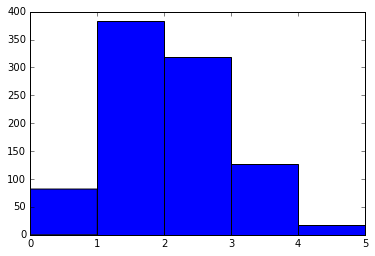

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt

print(len(perfect_match),len(neural_match),len(ensemble_match))
plt.hist(interesection_size, bins = 5)


[14, 0, 18, 129, 2, 82, 273, 0, 0, 0, 36, 0, 21, 0, 21, 0, 0]
['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']


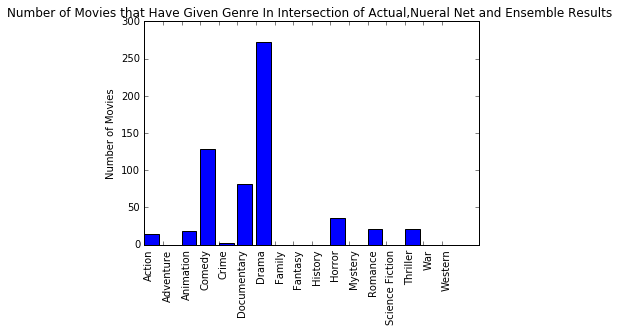

In [132]:

number_of_agreeing_genres = [0]*17

for i in range(len(intersections)):
    for g in intersections[i]:
        number_of_agreeing_genres[genres.index(g)] += 1
print(number_of_agreeing_genres)      
print(genres)
ind = np.arange(17)
fig, ax = plt.subplots()
ax.bar(ind,number_of_agreeing_genres)
ax.set_xticks(np.arange(len(genres)))
ax.set_xticklabels(genres, rotation=90, ha='left')
ax.set_ylabel("Number of Movies")
ax.set_title("Number of Movies that Have Given Genre In Intersection of Actual,Nueral Net and Ensemble Results ")
